In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam as adam
from tensorflow.keras import backend
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
from itertools import count
from random import shuffle

In [5]:
my_path = 'D:\s4353631\ISIC2018_'
datasets = {'train': [0, .7],
            'val': [.7, .9],
            'test': [.9, 1]}

x_paths = glob.glob(my_path + 'x' + '/*.jpg')
shuffle(x_paths)
labels = [i[-11:-4] for i in x_paths]

orig_shapes = []
for i in x_paths:
    i = tf.io.read_file(i)
    i = tf.io.decode_png(i)
    orig_shapes.append(tuple(i.shape[:-1]))

data_dict = {}

for i in datasets.keys():
    lower_bound = int(datasets[i][0] * len(labels))
    upper_bound = int(datasets[i][1] * len(labels))

    data_dict[i] = {'labels': labels[lower_bound:upper_bound],
                    'orig_shapes': orig_shapes[lower_bound:upper_bound],
                    'quantity': upper_bound - lower_bound}

In [47]:
def data_generator(dataset):
    for i in count():
        get_label = lambda i=i: data_dict['train']['labels'][i]
        
        x = tf.io.read_file('D:\s4353631\ISIC2018_x\ISIC_' + str(get_label()) + '.jpg')
        x = tf.io.decode_jpeg(x)

        y = tf.io.read_file('D:\s4353631\ISIC2018_y\ISIC_' + str(get_label()) + '_segmentation.png')
        y = tf.io.decode_png(y)

        x, y = [tf.cast(j, tf.float32) / 255 for j in (x, y)]
        x, y = [tf.image.resize(j, [200, 200]) for j in (x, y)]
#         x, y = [tf.reshape(j, [200, 200, -1]) for j in (x, y)] 

        y = tf.math.round(y)
        
        yield x, y

In [48]:
for i in datasets.keys():
    data_dict[i]['dset'] = tf.data.Dataset.from_generator(
        lambda: data_generator(i),
        (tf.float32, tf.float32),
        (tf.TensorShape([200, 200, 3]), tf.TensorShape([200, 200, 1])))

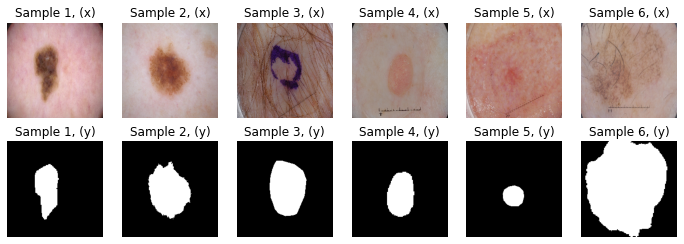

In [55]:
x_sample, y_sample = next(iter(data_dict['train']['dset'].batch(6)))

fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(12, 4))
labels = ['x', 'y']

for i in range(6):
    ax[0][i].imshow(x_sample[i])
    ax[0][i].axis('off')
    ax[0][i].set_title('Sample ' + str(i + 1) + ', (x)')
    
    ax[1][i].imshow(tf.reshape(y_sample[i], [200, 200]), cmap='gray')
    ax[1][i].axis('off')
    ax[1][i].set_title('Sample ' + str(i + 1) + ', (y)')
    
plt.show()

In [64]:
class My_Conv2D(tf.keras.layers.Layer):
    def __init__(self, filters, activation=True, strides=(1, 1), kernel=3, \
            alpha=10^-2, regularizer=tf.keras.regularizers.l2(10^-2), 
            initializer=tf.keras.initializers.he_uniform()):
        '''
        Inherits from tf.keras.layers.Layer, consists of a 3X3 convolution of 
        variable stride passing to an optional activation (tf.keras.layers.LeakyReLU). 
        
        Args:
            filters (int): Number of convolutional filters.
            activation (bool): Whether or not to include activation.
            strides (tuple): Stride in each dimension.
            kernel (int): Square filter side length.
            alpha (float): Gradient of tf.keras.layers.LeakyReLU below activation.
            kernel_regularizer (tf.keras.regularizers): Regularization algorithm.
        '''
        super(My_Conv2D, self).__init__()
        self.conv2d_1 = tf.keras.layers.Conv2D(filters, kernel, strides=strides, \
           padding='same', kernel_initializer=initializer)
        self.activation = activation
        if self.activation:
            self.batchnorm_1 = tf.keras.layers.BatchNormalization()
            self.leakyrelu_1 = tf.keras.layers.LeakyReLU(alpha=alpha)
        
    def call(self, x):
        '''
        Defines the forward pass; the backward pass is computed via TensorFlow's 
        autodifferentiation algorithm.
        
        Args:
            x (tf.Tensor): Image tensor, remapped if the layer is deep.
            
        Returns:
            x (tf.Tensor): Image tensor as processed by the layer.
        '''
        x = self.conv2d_1(x)
        if self.activation:
            x = self.batchnorm_1(x)
            x = self.leakyrelu_1(x)
        
        return x

class Downshift(tf.keras.layers.Layer):

    def __init__(self, filters, bottom=False, dropout=0):
        '''
        Inherits from tf.keras.layers.Layer, consists of a residual context module 
        passing to a stride 2X2 MyConv2D layer. The residual context module contains 
        two My_Conv2D layers, the first without activation, separated by dropout. 
        The initial tensor is then added element-wise to the output before being 
        stored as x_res and passed to the stride 2X2 convolution with twice as many 
        filters; x_res is later employed for context aggregation by Upshift. An option 
        to not compute the stride 2X2 convolution is included so that the UNet 
        architecture can effectively 'bottom out'. Combining the residual context module 
        with the stride 2X2 convolution in this way is useful for fast prototyping with 
        small networks as these converge much more quickly than larger equivalents, 
        offering a proof of concept.

        Args:
            filters (int): Number of filters to be used in each convolutional layer of 
                the residual context module.
            bottom (bool): Whether or not to 'bottom out' by not including the stride 
                2X2 convolution.
            dropout (float): Dropout probability.
        '''
        
        super(Downshift, self).__init__()
        self.bottom = bottom
        
        self.conv2d_1 = My_Conv2D(filters, activation=False)
        self.dropout_1 = tf.keras.layers.Dropout(dropout)
        self.conv2d_2 = My_Conv2D(filters)
        self.add_1 = tf.keras.layers.Add()
        self.conv2d_3 = My_Conv2D(int(filters * 2), strides=(2, 2))
        
    def call(self, x_init):
        '''
        Defines the forward pass; the backward pass is computed via TensorFlow's 
        autodifferentiation algorithm.
        
        Args:
            x_init (tf.Tensor): Image tensor, remapped if the layer is deep.
            
        If self.bottom is not true:
            
        Returns:
            x (tf.Tensor): Image tensor as processed by the layer.
            x_res (tf.Tensor): Image tensor as processed by the layer, but 
                excluding the stride 2X2 convolution.
                
        If self.bottom is true:
        Returns:
            x_res (tf.Tensor): Image tensor as processed by the layer, but 
                excluding the stride 2X2 convolution.
        '''
        x = self.conv2d_1(x_init)
        x = self.dropout_1(x)
        x = self.conv2d_2(x)
        x_res = self.add_1([x, x_init])
        
        if self.bottom:
            return x_res
        else:
            x = self.conv2d_3(x)

            return x, x_res
    
class Upshift(tf.keras.layers.Layer):
    '''
    Inherits from tf.keras.layers.Layer, consists of an upsampling module passing 
    to a 
    '''
    def __init__(self, filters, top=False):
        super(Upshift, self).__init__()
        self.top = top
        
        self.upsampling_1 = tf.keras.layers.UpSampling2D()
        self.conv2d_1 = My_Conv2D(filters)
        self.concatenate_1 = tf.keras.layers.Concatenate()
        self.conv2d_2 = My_Conv2D(filters)
        self.conv2d_3 = My_Conv2D(int(filters / 2), kernel=1)
        self.seg_1 = tf.keras.layers.Conv2D(1, 1, activation='softmax', padding='same')
        
    def call(self, X):
        x, x_res = X
        x = self.upsampling_1(x)
        x = self.conv2d_1(x)
        x = self.concatenate_1([x, x_res])
        x = self.conv2d_2(x)
        x = self.conv2d_3(x)
        x_seg = self.seg_1(x)
        
        if self.top:
            return x_seg
        
        else:
            return x, x_seg

In [65]:
class Your_UNet(tf.keras.Model):
    def __init__(self, input_img_shape):
        super(Your_UNet, self).__init__()
        self.input_img_shape = input_img_shape
        
        self.conv2d_1 = My_Conv2D(16)
        
        self.downshift_1 = Downshift(16)
        self.downshift_2 = Downshift(32)
        self.downshift_3 = Downshift(64, bottom=True)
        
        self.upshift_1 = Upshift(32)
        self.upshift_2 = Upshift(16, top=True)
        
        self.upsampling_1 = tf.keras.layers.UpSampling2D()
        self.add_1 = tf.keras.layers.Add()
        
        self.output_1 = tf.keras.layers.Conv2D(1, 1, activation='softmax', padding='same')
        
    def call(self, x_0):
        x_1 = self.conv2d_1(x_0)
        
        x_2, x_2_res = self.downshift_1(x_1)
        x_3, x_3_res = self.downshift_2(x_2)
        x_4 = self.downshift_3(x_3)

        x_5, x_5_res = self.upshift_1([x_4, x_3_res])
        x_6 = self.upshift_2([x_5, x_2_res])
        
        x_7 = self.upsampling_1(x_5_res)
        x_8 = self.add_1([x_7, x_6])

        x_9 = self.output_1(x_8)
        
        return x_9
    
    def build_graph(self):
        x_0 = tf.keras.Input(shape=self.input_img_shape)
        
        return tf.keras.Model(inputs=[x_0], outputs=self.call(x_0))

In [42]:
def smoothed_jaccard_distance(y_ground, y_predicted, smoothing=10):
    intersection = backend.sum(y_ground*y_predicted, axis=(1, 2))
    union = backend.sum(y_ground + y_predicted, axis=(1, 2))
    jaccard_index = (intersection + smoothing)/(union - intersection + smoothing)
    
    return (1 - jaccard_index)*smoothing

In [43]:
def dice_coe(y_ground, y_predicted):
    intersection = backend.sum(y_ground * y_predicted, axis=(1, 2))
    union = backend.sum(y_ground + y_predicted, axis=(1, 2))
    
    return 2 * (intersection) / (union)

In [66]:
input_img_shape = (200, 200, 3)
model = Your_UNet(input_img_shape)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    10**-3,
    decay_steps=10**3,
    decay_rate=0.7,
    staircase=True)
my_opt = adam(learning_rate=lr_schedule)

model.compile(optimizer=my_opt, 
              loss=smoothed_jaccard_distance,
              metrics=[dice_coe])

model.build(input_shape=(None, *input_img_shape))

model.build_graph().summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
my__conv2d_112 (My_Conv2D)      (None, 200, 200, 16) 512         input_6[0][0]                    
__________________________________________________________________________________________________
downshift_21 (Downshift)        ((None, 100, 100, 32 9472        my__conv2d_112[0][0]             
__________________________________________________________________________________________________
downshift_22 (Downshift)        ((None, 50, 50, 64), 37376       downshift_21[0][0]               
____________________________________________________________________________________________

In [ ]:
history = model.fit(data_dict['train']['dset'].batch(2), epochs=3,
                    validation_data=data_dict['val']['dset'].batch(2), verbose=1)